In [1]:
import tobac
import iris
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import numpy as np
import tqdm

%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

# TODO
- Need to optimise tracking parameters for problem
- Consider merge and splits?
- How to go about associating max gusts with environment. Take max over track first?

In [2]:
#Load BARPA gust data

f = xr.open_dataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/era/erai/historical/r0/20071029T0000Z/20071228T0000Z/pp26/max_wndgust10m-pp26-BARPAC-M_km2p2-20071228T0000Z-20071231T0000Z.nc")
f = f.max_wndgust10m
f = f.sel(time=slice("2007-12-31 02:00","2007-12-31 10:00")).to_iris()

In [3]:
#Set parameters for identifying features, and perform feature ID

parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['min_distance']=0
parameters_features['target']='maximum'
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[25]
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=9

Features = tobac.feature_detection.feature_detection_multithreshold(f,2200,**parameters_features)

In [4]:
#Set parameters for segmentation, and perform segmentation

parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=15  

Mask,Features_gust=tobac.segmentation_2D(Features,f,2200,**parameters_segmentation)


In [5]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=10*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10

dt = 10*60
dxy = 2200
Track=tobac.linking_trackpy(Features,f,dt=dt,dxy=dxy,**parameters_linking)


Frame 47: 1 trajectories present.


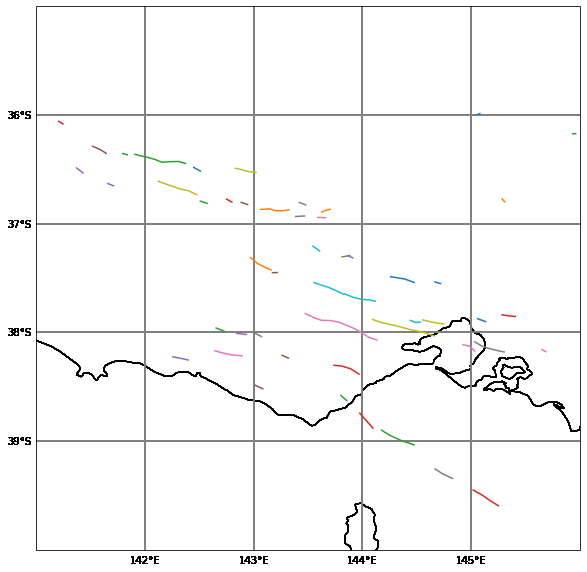

In [6]:
axis_extent=[141,146,-40,-35]
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

In [7]:
Mask_np = xr.DataArray.from_iris(Mask).values.flatten()
f_np = xr.DataArray.from_iris(f).values.flatten()
f_np = f_np[Mask_np>0]
Mask_np = Mask_np[Mask_np>0]
maxs = [np.nanmax(np.where(Mask_np==i,f_np,np.nan)) for i in Track.feature]
Track["max_field"] = maxs

In [8]:
animation_tobac=tobac.animation_mask_field(track=Track,features=Features,field=f,mask=Mask,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=45,extend='max',cmap='Reds',
                                          interval=500,figsize=(20,16),
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)


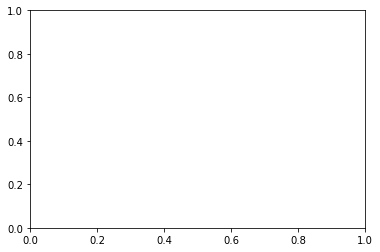

In [9]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_tobac.to_html5_video())